In [1]:
import functools
from absl import logging
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

### Do an tf.dataset

In [2]:
def build_input_fn(builder, global_batch_size):
  """Build input function.

  Args:
    builder: TFDS builder for specified dataset.
    global_batch_size: Global batch size.
  Returns:
    A function that accepts a dict of params and returns a tuple of images and
    features, to be used as the input_fn in TPUEstimator.
  """

  def _input_fn(input_context):
    """Inner input function."""
    batch_size = input_context.get_per_replica_batch_size(global_batch_size)
    logging.info('Global batch size: %d', global_batch_size)
    logging.info('Per-replica batch size: %d', batch_size)
    preprocess_fn_pretrain = get_preprocess_fn(color_distortion=True)
    num_classes = builder.info.features['label'].num_classes

    def map_fn(image, label):
      """Produces multiple transformations of the same batch."""
      xs = []
      for _ in range(2):  # Two transformations
        xs.append(preprocess_fn_pretrain(image))
      image = tf.concat(xs, -1)
      label = tf.one_hot(label, num_classes)
      return image, label

    dataset = builder.as_dataset(
        split='train',
        shuffle_files=True,
        as_supervised=True)
    
    # The dataset is always sharded by number of hosts.
    # num_input_pipelines is the number of hosts rather than number of cores.
    if input_context.num_input_pipelines > 1:
      dataset = dataset.shard(input_context.num_input_pipelines,
                              input_context.input_pipeline_id)

    buffer_multiplier = 10
    dataset = dataset.shuffle(batch_size * buffer_multiplier)
    dataset = dataset.repeat(-1)
    dataset = dataset.map(
        map_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

  return _input_fn


def build_distributed_dataset(builder, batch_size, strategy):
  input_fn = build_input_fn(builder, batch_size)
  return strategy.experimental_distribute_datasets_from_function(input_fn)


def get_preprocess_fn(color_distortion):
  
  return functools.partial(
      preprocess_image,
      height=100,
      width=100,
      color_distort=color_distortion)

### Preprocess for pretrain

In [3]:
CROP_PROPORTION = 0.875

def random_brightness(image, max_delta):
    #Only multiplicative change of brightness
    factor = tf.random.uniform([], tf.maximum(1.0-max_delta, 0), 1.0+max_delta)
    image = image * factor
    return image


def color_jitter_rand(image, brightness=0, contrast=0, saturation=0, hue=0):
    #Distorts the color of the image (jittering order is random)
    with tf.name_scope('distort_color'):
        def apply_transform(i,x):
            #apply the i-th transformation
            def brightness_foo():
                if brightness == 0:
                    return x
                else:
                    return random_brightness(x, max_delta=brightness)
            
            def contrast_foo():
                if contrast == 0:
                    return x
                else:
                    return tf.image.random_contrast(x, lower=1-contrast, upper=1+contrast)
            
            def saturation_foo():
                if saturation == 0:
                    return x
                else:
                    return tf.image.random_saturation(x, lower=1-saturation, upper=1+saturation)

            def hue_foo():
                if hue == 0:
                    return x
                else:
                    return tf.image.random_hue(x, max_delta = hue)
            
            x = tf.cond(tf.less(i, 2),
                lambda: tf.cond(tf.less(i, 1), brightness_foo, contrast_foo),
                lambda: tf.cond(tf.less(i, 3), saturation_foo, hue_foo))
            return x

        perm = tf.random.shuffle(tf.range(4))
        for i in range(4):
            image = apply_transform(perm[i], image)
            image = tf.clip_by_value(image, 0., 1.)
        return image


def color_jitter(image, strength):
    #Distorts the color of the image
    #random_order: A bool, specifying whether to randomize the jittering order.
    brightness = 0.8 * strength
    contrast = 0.8 * strength
    saturation = 0.8 * strength
    hue = 0.2 * strength
    #removed color_jitter_nonrand
    return color_jitter_rand(image, brightness, contrast, saturation, hue)


def to_grayscale(image, keep_channels=True):
    image = tf.image.rgb_to_grayscale(image)
    if keep_channels:
        image = tf.tile(image, [1, 1, 3])
    return image


def random_apply(func, p, x):
    #Randomly apply function func to x with probability p.
    return tf.cond(tf.less(
        tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
        tf.cast(p, tf.float32)), lambda: func(x), lambda: x)


def random_color_jitter(image, p=1.0):

    def _transform(image):
        color_jitter_t = functools.partial(color_jitter, strength=1.0)
        image = random_apply(color_jitter_t, p=0.8, x=image)
        return random_apply(to_grayscale, p=0.2, x=image)
    
    return random_apply(_transform, p=p, x = image)


def center_crop(image, height, width, crop_proportion):
    #Crops to center of image and rescales to desired size
    #removed original functions, the result is the same if we use this
    #instead of original func. (almost in our case) see transformations.py in the folder Notebooks_for_debug
    #image = tf.image.central_crop(image, crop_proportion)
    image = tf.image.resize([image], [height, width], method=tf.image.ResizeMethod.BICUBIC)[0]

    return image


def preprocess_for_train(image, height, width, color_distort=True, crop=True, flip=True):
    #Preprocesses the given image for train
    if crop:
        #removed random crop (original script) because we need to do a center crop
        image = center_crop(image, height, width, crop_proportion=CROP_PROPORTION)
        ##add random crop to center croped image? like this
        # image = tf.image.random_crop()
    if flip:
        image = tf.image.random_flip_left_right(image)
    if color_distort:
        image = random_color_jitter(image)
    image = image = tf.reshape(image, [height, width, 3])
    image = tf.clip_by_value(image, 0., 1.)
    return image


####################### Main function ##########################
def preprocess_image(image, height, width, color_distort=True):
    #color_distort: whether to apply the color distortion.
    #Returns A preprocessed image Tensor of range [0,1]
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return preprocess_for_train(image, height, width, color_distort)

### Instanciate the dataset

In [4]:
#use one or more GPU's
strategy = tf.distribute.MirroredStrategy()
builder = tfds.builder('cats_vs_dogs', data_dir='cat_dog/')
builder.download_and_prepare()
ds = build_distributed_dataset(builder, 16, strategy)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Instructions for updating:
rename to distribute_datasets_from_function


Instructions for updating:
rename to distribute_datasets_from_function


### Show a preprocessed batch

In [5]:
#iter over ds
iterator = iter(ds)
#get a minibatch
images, _ = next(iterator)

In [6]:
#function to convert float32 image to uint8
def convert(img, target_type_min=0, target_type_max=255, target_type='uint8'):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

In [7]:
#convert images in the batchsize
images_from_0to3=[]
images_from_0to6=[]
for i in range(16):
    img1 = convert(images[i,:,:,:3].numpy())
    img2 = convert(images[i,:,:,3:].numpy())
    images_from_0to3.append(img1)
    images_from_0to6.append(img2)

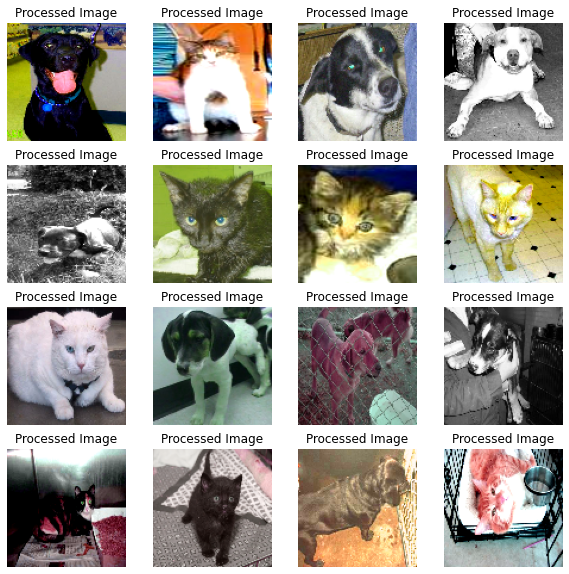

In [8]:
plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(images_from_0to3[i])
  #label = label_batch[i]
  plt.title('Processed Image')
  plt.axis("off")

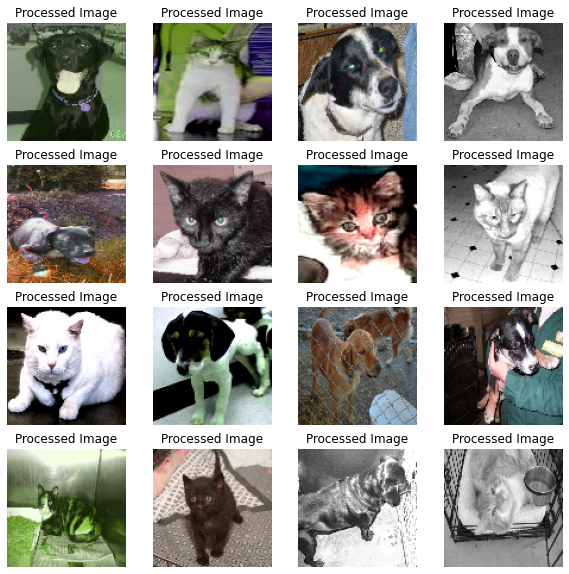

In [9]:
plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(images_from_0to6[i])
  plt.title('Processed Image')
  plt.axis("off")

In [ ]:
dss = 